In [133]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import seaborn as sns
import time

### Import MNIST

In [139]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

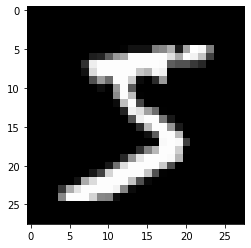

In [140]:
%matplotlib inline
import matplotlib.pyplot as plt
first_digit = X[0]
image = first_digit.reshape(28,28).astype(np.uint8)

plt.imshow(image, cmap='gray')

# Basic NN

Here we want to train a basic NN for the MNIST dataset.

In [157]:
class Layer:
    def __init__(self, prev_size, layer_size, activation_function, lr):
        assert activation_function in ['ReLu', 'Sigmoid', 'Softmax'], 'Unknown activation function'
        if activation_function=='ReLu':
            self.activation_function = self.activate_relu
        elif activation_function=='Sigmoid':
            self.activation_function = self.activate_sigmoid
        elif activation_function=='Softmax':
            self.activation_function = self.activate_softmax
            
        self.W = np.random.randn(prev_size, layer_size)
        self.Z = np.zeros((1, layer_size))
        self.A = np.zeros((1, layer_size))
        self.lr = lr
        
    def forward(self, X):
        return self.activation_function(np.dot(X, self.W))
        
    def backwards(self, X, dA):
        Z = np.dot(X,self.W)
        dZ = dA * self.activation_function(Z, derivate=True)
        dW = np.outer(X.T, dZ)
        self.W -= self.lr * dW
        return np.dot(self.W, dA/self.activation_function(Z, derivate=True).T)
        
    def activate_relu(self, y, derivate=False):
        if not derivate:
            return max(0, y)
        else:
            if y >= 0:
                return 1 
            else:
                return 0
            
    def activate_sigmoid(self, z, derivate=False):
        a = 1/(1+np.exp(-z))
        if not derivate:
            return a
        else:
            return a * (1-a)
        
    def activate_softmax(self, x, derivate=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivate:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)
            
class NN:
    def __init__(self, layer_sizes, activation_function, lr):
        self.n_layers = len(layer_sizes)
        self.layers=[]
        self.layer_outputs=[]
        
        #Initialize output of the input layer
        self.layer_outputs.append(np.zeros((1,layer_sizes[0])))
        
        #Initialize layers and their outputs
        for i in range(1, self.n_layers):
            new_layer = Layer(layer_sizes[i-1], layer_sizes[i], activation_function, lr)
            self.layers.append(new_layer)
            self.layer_outputs.append(np.zeros(layer_sizes[i]))
        
        final_layer = Layer(layer_sizes[-1], 10, 'Softmax', lr)
        self.layers.append(final_layer)
        self.layer_outputs.append(np.zeros(10))

    
    def forward_pass(self, X): 
        layer_outputs = [X]
        for i in range(self.n_layers):
            layer_outputs.append(self.layers[i].forward(layer_outputs[i])) 
        return layer_outputs
            
    def loss(self, Y, Y2):
        return np.sum(np.square(Y - Y2))
    
    def backward_pass(self, error):
        for i in reversed(range(self.n_layers)):
            error = self.layers[i].backwards(self.layer_outputs[i], error)
        return 0
        
    def full_pass(self, X, y):
        layer_outputs = self.forward_pass(X)
        error = y - layer_outputs[-1]
        self.backward_pass(error)
        return np.argmax(layer_outputs[-1]), self.loss(y, layer_outputs[-1])

In [158]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def one_hot(y):
    result = np.zeros((10))
    result[int(y)-1]=1
    return result

print(one_hot(2))

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


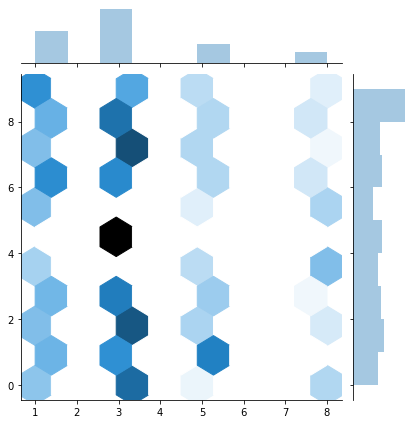

In [159]:
layer_sizes = [784, 100, 30]
dnn = NN(layer_sizes, 'Sigmoid', 0.1)


minibatch = zip(x_train[:1000],y_train[:1000])
losses, predictions = [], []
for couple in minibatch:
    y = couple[1]
    onehot_y = one_hot(y)
    prediction, loss = dnn.full_pass(couple[0], onehot_y)
    losses.append(loss)
    predictions.append(prediction)

sns.jointplot(x=predictions, y=y_train[:1000], kind='hex')

Here is the paper we will follow for implementation of dropout: https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf